In [73]:
from mpmath import *
from sympy import *
import numpy as np
import matplotlib.pyplot as plt

In [102]:
# Define symbolic variables for DH parameters
alpha1, alpha2, alpha3, alpha4, alpha5, alpha6 = symbols('alpha1:7')
a1, a2, a3, a4, a5, a6 = symbols('a1:7')
d1, d2, d3, d4, d5, d6 = symbols('d1:7')
theta1, theta2, theta3, theta4, theta5, theta6 = symbols('theta1:7')

In [103]:
DH_Table = {
    alpha1: pi/2,  a1: 0,       d1: 183.3/1000, theta1: pi/2 + theta1,
    alpha2: 0,     a2: 737.31/1000,  d2: 0,     theta2: pi/2 + theta2,
    alpha3: 0,     a3: 387.8/1000,   d3: 0,     theta3: theta3,
    alpha4: pi/2,  a4: 0,       d4: -95.5/1000, theta4: -pi/2 + theta4,
    alpha5: pi/2,  a5: 0,       d5: -115.5/1000,theta5: pi + theta5,
    alpha6: 0,     a6: 0,       d6: -76.8/1000, theta6: -pi + theta6
}



In [104]:
# Define the DH transformation matrix
def DH_tfmat(alpha, a, d, theta):
    return Matrix([
        [cos(theta), -sin(theta)*cos(alpha), sin(theta)*sin(alpha), a*cos(theta)],
        [sin(theta), cos(theta)*cos(alpha), -cos(theta)*sin(alpha), a*sin(theta)],
        [0, sin(alpha), cos(alpha), d],
        [0, 0, 0, 1]
    ])

# Create transformation matrices for each joint using the DH parameters
T0_1 = DH_tfmat(alpha1, a1, d1, theta1).subs(DH_Table)
T1_2 = DH_tfmat(alpha2, a2, d2, theta2).subs(DH_Table)
T2_3 = DH_tfmat(alpha3, a3, d3, theta3).subs(DH_Table)
T3_4 = DH_tfmat(alpha4, a4, d4, theta4).subs(DH_Table)
T4_5 = DH_tfmat(alpha5, a5, d5, theta5).subs(DH_Table)
T5_EE = DH_tfmat(alpha6, a6, d6, theta6).subs(DH_Table)


In [105]:
# Calculate the end-effector transformation matrix
T0_EE = T0_1 * T1_2 * T2_3 * T3_4 * T4_5 * T5_EE
T0_EE = simplify(T0_EE)

# Define the tool offset in the Z-axis direction
tool_length = 4.5  # Tool length in cm
T_EE_tool = Matrix([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, tool_length],
    [0, 0, 0, 1]
])

# Update the end-effector transformation with the tool offset
T0_EE_with_tool = T0_EE * T_EE_tool

# Compute cumulative transformation matrices for Jacobian calculation
T0_2 = T0_1 * T1_2
T0_3 = T0_2 * T2_3
T0_4 = T0_3 * T3_4
T0_5 = T0_4 * T4_5

# Extract position vectors (origins) and z-axis vectors for Jacobian
O0 = Matrix([0, 0, 0])
O1 = T0_1[:3, 3]
O2 = T0_2[:3, 3]
O3 = T0_3[:3, 3]
O4 = T0_4[:3, 3]
O5 = T0_5[:3, 3]
O6 = T0_EE_with_tool[:3, 3]

Z0 = Matrix([0, 0, 1])
Z1 = T0_1[:3, 2]
Z2 = T0_2[:3, 2]
Z3 = T0_3[:3, 2]
Z4 = T0_4[:3, 2]
Z5 = T0_5[:3, 2]

# Compute linear and angular velocity parts of the Jacobian matrix
Jv1 = Z0.cross(O6 - O0)
Jv2 = Z1.cross(O6 - O1)
Jv3 = Z2.cross(O6 - O2)
Jv4 = Z3.cross(O6 - O3)
Jv5 = Z4.cross(O6 - O4)
Jv6 = Z5.cross(O6 - O5)

Jw1 = Z0
Jw2 = Z1
Jw3 = Z2
Jw4 = Z3
Jw5 = Z4
Jw6 = Z5

In [106]:
# Combine linear and angular components into the Jacobian matrix
Jacobian_matrix = Matrix.vstack(
    Matrix.hstack(Jv1, Jv2, Jv3, Jv4, Jv5, Jv6),
    Matrix.hstack(Jw1, Jw2, Jw3, Jw4, Jw5, Jw6)
)

for i in range(Jacobian_matrix.shape[0]):  # Iterate over the rows
    print(f"\033[1mRow {i+1}:\033[0m")
    pprint(Jacobian_matrix.row(i))

# Function to compute the full Jacobian given current joint angles
def jacobian(q):
    J_full = Jacobian_matrix.evalf(subs={
        theta1: q[0],
        theta2: q[1],
        theta3: q[2],
        theta4: q[3],
        theta5: q[4],
        theta6: q[5]
    })
    return np.array(J_full).astype(np.float64)

# Function to compute joint velocities given end-effector velocity
def compute_joint_velocities(q, v_ee):
    J = jacobian(q)  # Use full 6x6 Jacobian for 6D motion
    
    J_inv = np.linalg.pinv(J + np.eye(J.shape[0]) * 1e-6)
    return J_inv.dot(v_ee)

def compute_joint_accelerations(q, q_dot, a_ee, dt):
    J = jacobian(q)  # Compute the current Jacobian
    J_inv = np.linalg.pinv(J + np.eye(J.shape[0]) * 1e-6)
    
    # Compute Jacobian derivative (J_dot) using finite differences
    J_next = jacobian(q + q_dot * dt)
    J_dot = (J_next - J) / dt
    
    # Compute joint accelerations
    q_ddot = J_inv.dot(a_ee - J_dot.dot(q_dot))
    
    return q_ddot

# Generate a semi-circular trajectory in the counterclockwise direction with center (5, 5)
def generate_semi_circle_trajectory(radius, steps, time, center=(5, 5)):
    angles = np.linspace(0, np.pi, steps)
    x_vals = center[0] + radius * np.cos(angles)
    y_vals = center[1] + radius * np.sin(angles)
    v_vals = np.vstack([np.gradient(x_vals, time/steps), np.gradient(y_vals, time/steps), np.zeros(steps)])
    return np.array([x_vals, y_vals]).T, v_vals.T

# Generate a straight-line trajectory in the negative Y-direction
def generate_straight_line_y(start_point, length, steps, time):
    y_vals = np.linspace(start_point[1], start_point[1] - length, steps)  # Move in negative y-direction
    x_vals = np.full(steps, start_point[0])  # Keep x constant
    v_vals = np.vstack([np.zeros(steps), np.gradient(y_vals, time/steps), np.zeros(steps)])  # No change in x or z
    return np.array([x_vals, y_vals]).T, v_vals.T

# Generate a straight-line trajectory in the positive x-direction
def generate_straight_line_x(start_point, length, steps, time):
    x_vals = np.linspace(start_point[0], start_point[0] + length, steps)  # Move in positive x-direction
    y_vals = np.full(steps, start_point[1])  # Keep y constant
    v_vals = np.vstack([np.gradient(x_vals, time/steps), np.zeros(steps), np.zeros(steps)])  # No change in y or z
    return np.array([x_vals, y_vals]).T, v_vals.T

# Generate a straight-line trajectory in the positive y-direction
def generate_straight_line_y_pos(start_point, length, steps, time):
    y_vals = np.linspace(start_point[1], start_point[1] + length, steps)  # Move in positive y-direction
    x_vals = np.full(steps, start_point[0])  # Keep x constant
    v_vals = np.vstack([np.zeros(steps), np.gradient(y_vals, time/steps), np.zeros(steps)])  # No change in x or z
    return np.array([x_vals, y_vals]).T, v_vals.T

Row 1:
[-4.4232⋅sin(θ₁)⋅cos(θ₅) + 0.0955⋅sin(θ₁) + 0.73731⋅sin(θ₂)⋅cos(θ₁) + 4.4232⋅s ↪

↪ in(θ₅)⋅cos(θ₁)⋅cos(θ₂ + θ₃ + θ₄) + 0.3878⋅sin(θ₂ + θ₃)⋅cos(θ₁) + 0.1155⋅sin( ↪

↪ θ₂ + θ₃ + θ₄)⋅cos(θ₁)  (-4.4232⋅sin(θ₅)⋅sin(θ₂ + θ₃ + θ₄) + 0.73731⋅cos(θ₂)  ↪

↪ + 0.3878⋅cos(θ₂ + θ₃) + 0.1155⋅cos(θ₂ + θ₃ + θ₄) - 2.77555756156289e-17)⋅sin ↪

↪ (θ₁)  (-4.4232⋅sin(θ₅)⋅sin(θ₂ + θ₃ + θ₄) + 0.3878⋅cos(θ₂ + θ₃) + 0.1155⋅cos( ↪

↪ θ₂ + θ₃ + θ₄) - 2.77555756156289e-17)⋅sin(θ₁)  (0.3878⋅sin(θ₂)⋅sin(θ₃) - 4.4 ↪

↪ 232⋅sin(θ₅)⋅sin(θ₂ + θ₃ + θ₄) - 0.3878⋅cos(θ₂)⋅cos(θ₃) + 0.3878⋅cos(θ₂ + θ₃) ↪

↪  + 0.1155⋅cos(θ₂ + θ₃ + θ₄) - 2.77555756156289e-17)⋅sin(θ₁)  -(-(-sin(θ₂)⋅si ↪

↪ n(θ₃) + cos(θ₂)⋅cos(θ₃))⋅cos(θ₄) - (-sin(θ₂)⋅cos(θ₃) - sin(θ₃)⋅cos(θ₂))⋅sin( ↪

↪ θ₄))⋅(4.4232⋅sin(θ₁)⋅cos(θ₅) + 1.38777878078145e-17⋅sin(θ₁) + 0.3878⋅sin(θ₂) ↪

↪ ⋅cos(θ₁)⋅cos(θ₃) + 0.3878⋅sin(θ₃)⋅cos(θ₁)⋅cos(θ₂) - 4.4232⋅sin(θ₅)⋅cos(θ₁)⋅c ↪

↪ os(θ₂ + θ₃ + θ₄) - 0.3878⋅sin(θ₂ + θ₃)⋅cos(θ₁) - 0.1155⋅sin(θ₂ + θ₃ + θ₄)⋅co ↪

↪ s(θ₁)) 

In [107]:
def generate_combined_trajectory(radius, length_y, length_x, steps, time):
    # Generate the semi-circle trajectory
    pos_circle, vel_circle = generate_semi_circle_trajectory(radius, steps, time)
    
    # Generate the straight line in the negative Y-direction
    pos_line_y, vel_line_y = generate_straight_line_y(pos_circle[-1], length_y, steps, time)
    
    # Generate the straight line in the positive X-direction
    pos_line_x, vel_line_x = generate_straight_line_x(pos_line_y[-1], length_x, steps, time)
    
    # Generate the straight line in the positive Y-direction
    pos_line_y_pos, vel_line_y_pos = generate_straight_line_y_pos(pos_line_x[-1], length_y, steps, time)
    
    # Combine all trajectories
    positions = np.vstack([pos_circle, pos_line_y[1:], pos_line_x[1:], pos_line_y_pos[1:]])
    velocities = np.vstack([vel_circle, vel_line_y[1:], vel_line_x[1:], vel_line_y_pos[1:]])
    
    # Calculate accelerations
    dt = time / steps
    accelerations = np.zeros_like(velocities)
    accelerations[1:-1] = (velocities[2:] - velocities[:-2]) / (2 * dt)
    accelerations[0] = (velocities[1] - velocities[0]) / dt
    accelerations[-1] = (velocities[-1] - velocities[-2]) / dt
    
    return positions, velocities, accelerations

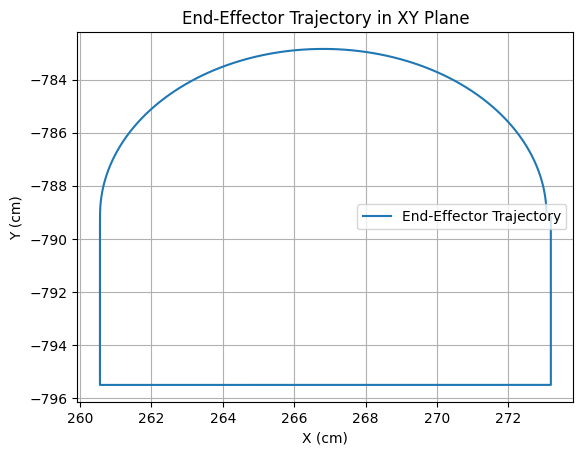

In [ ]:
# Total time for trajectory
T_total = 20  # seconds
steps = 100  # Number of trajectory steps for smoothness
dt = 0.25
radius = 5  # Radius of semicircle in cm

# q_init = np.array([-pi/4, pi/5, pi/4, pi/6, pi/4, pi/6])
q_init = np.array([pi/6, pi/6, pi/6, pi/6, pi/6, 0])

# Generate the semi-circle trajectory with center (5, 5)
target_positions, target_velocities = generate_semi_circle_trajectory(radius, steps, T_total)

# start_circle_x, start_circle_y = target_positions[0]

# Generate the straight line in the negative Y-direction
target_positions_line, target_velocities_line = generate_straight_line_y(target_positions[-1], 5, steps, T_total)

# Generate the straight line in the positive X-direction (adjusted for exactly 10 cm)
target_positions_x, target_velocities_x = generate_straight_line_x(target_positions_line[-1], 10, steps, T_total)

# Generate the straight line in the positive Y-direction
target_positions_y, target_velocities_y = generate_straight_line_y_pos(target_positions_x[-1], 5, steps, T_total)

# Combine all trajectories
target_positions_combined = np.vstack([target_positions, target_positions_line, target_positions_x, target_positions_y])
target_velocities_combined = np.vstack([target_velocities, target_velocities_line, target_velocities_x, target_velocities_y])

# Store joint angles and end-effector positions
joint_angles_combined = [q_init]
end_effector_positions_combined = []


# Loop through each time step for the combined trajectory
for t in range(len(target_positions_combined)):
    q_current = joint_angles_combined[-1]
    v_ee = np.concatenate((target_velocities_combined[t], [0, 0, 0]))  # 6D velocity with no rotation (angular velocity is 0)
    
    # Compute joint velocities using inverse kinematics
    joint_velocities = compute_joint_velocities(q_current, v_ee)

    # Integrate joint velocities to get joint angles
    q_new = q_current + joint_velocities * dt
    joint_angles_combined.append(q_new)

    # Calculate the end-effector position for the current joint configuration
    T = T0_EE_with_tool.evalf(subs={theta1: q_new[0], theta2: q_new[1], theta3: q_new[2], theta4: q_new[3], theta5: q_new[4], theta6: q_new[5]})
    end_effector_position = T[:3, 3]
    end_effector_positions_combined.append(np.array(end_effector_position).flatten())

# Convert end-effector positions to numpy array for plotting
end_effector_positions_combined = np.array(end_effector_positions_combined)

# Plot the end-effector trajectory in the XY plane
plt.plot(end_effector_positions_combined[:, 0], end_effector_positions_combined[:, 1], label='End-Effector Trajectory')
# plt.scatter(start_x, start_y, color='red')
plt.xlabel('X (cm)')
plt.ylabel('Y (cm)')
plt.title('End-Effector Trajectory in XY Plane')
plt.legend(loc='center right')
plt.grid(True)
plt.show()

In [108]:
#Data reference for UR3 robot :https://www.universal-robots.com/articles/ur/application-installation/dh-parameters-for-calculations-of-kinematics-and-dynamics/
masses = np.array([2.0 , 3.42 , 1.26, 0.8, 0.8, 0.35], dtype=np.float64)
com = np.array([[0, -0.02, 0], [0.13, 0, 0.1157], [0.05, 0, 0.0238], [0, 0, 0.01], [0, 0, 0.01], [0, 0, -0.02]], dtype=np.float64)
F_tool = np.array([0,0,5.0,0,0,0], dtype=np.float64)

In [109]:
def compute_mass_matrix(q, masses, coms):
    M = np.zeros((6, 6))
    for i in range(6):
        J_i = jacobian(q)   # Full 6x6 Jacobian
        M_i = np.zeros((6, 6))
        M_i[:3, :3] = np.eye(3) * masses[i]  # Mass for linear components
        # Simplified inertia tensor (you may want to use actual inertia tensors for more accuracy)
        M_i[3:, 3:] = np.eye(3) * (masses[i] * np.sum(coms[i]**2))  
        M += J_i.T @ M_i @ J_i
    return M

# Modify the gravity matrix calculation as well
def compute_gravity_matrix(q, masses, coms):
    g = np.array([0, 0, -9.81])  # Gravity vector
    G = np.zeros(6)
    J = jacobian(q)
    for i in range(6):
        J_i = J[:3, i]  # Linear part of the Jacobian for the i-th joint
        G[i] = masses[i] * g.dot(J_i)
    return G

# The potential energy calculation remains the same
def compute_potential_energy(q, masses, coms):
    G = compute_gravity_matrix(q, masses, coms)
    print("Gravity Matrix: \n", G)
    return -q.dot(G)  # Negative because G is defined with opposite sign


def compute_mass_matrix_derivative(q, epsilon=1e-6):
    n = len(q)
    dM = np.zeros((n, n, n))
    
    for k in range(n):
        q_plus = q.copy()
        q_plus[k] += epsilon
        q_minus = q.copy()
        q_minus[k] -= epsilon
        M_plus = compute_mass_matrix(q_plus,  masses, com)
        M_minus = compute_mass_matrix(q_minus, masses, com)
        
        dM[:, :, k] = (M_plus - M_minus) / (2 * epsilon)
    
    return dM

def compute_coriolis_matrix(q, q_dot):
    n = len(q)
    C = np.zeros((n, n))
    
    # Compute the derivative of M with respect to q
    dM = compute_mass_matrix_derivative(q)
    
    for i in range(n):
        for j in range(n):
            for k in range(n):
                C[i, j] += 0.5 * (dM[i, j, k] + dM[i, k, j] - dM[k, j, i]) * q_dot[k]
    
    return C

In [110]:
def compute_torque(q, q_dot, q_dot_dot, F):
    M = compute_mass_matrix(q, masses, com)
    g = compute_gravity_matrix(q, masses, com)  # This function needs to be implemented
    C = compute_coriolis_matrix(q, q_dot)  # This function needs to be implemented
    J = jacobian(q)
    torque = M.dot(q_dot_dot) + C.dot(q_dot) + g - J.T.dot(F)
    return torque


dim of position 37
dim of velocity 37
dim of velocity 37
joint Torque
 [-5.43196178e+00  3.16101692e+04  7.83535408e+03  1.48390317e+03
 -8.04691608e+02 -3.80186375e-13]
joint Torque
 [-7.95343203e+00  3.15434467e+04  7.85111468e+03  1.48348449e+03
 -8.04806802e+02 -4.79093091e-13]
joint Torque
 [-9.80347985e+00  3.14798762e+04  7.86604771e+03  1.48350961e+03
 -8.04908663e+02 -6.56490690e-13]
joint Torque
 [-7.90892018e+00  3.14248836e+04  7.87834040e+03  1.48423515e+03
 -8.04855002e+02 -4.47828680e-13]
joint Torque
 [-5.06038682e+00  3.13847074e+04  7.88624419e+03  1.48544517e+03
 -8.04748200e+02  2.34768288e-13]
joint Torque
 [-1.60159047e+00  3.13642506e+04  7.88896403e+03  1.48698372e+03
 -8.04593681e+02  1.09721472e-12]
joint Torque
 [ 2.05020908e+00  3.13660186e+04  7.88621020e+03  1.48865512e+03
 -8.04404353e+02  1.60624668e-12]
joint Torque
 [ 5.45459941e+00  3.13897972e+04  7.87822001e+03  1.49025239e+03
 -8.04201824e+02  1.49027165e-12]
joint Torque
 [ 5.63951714e+00  3.14312

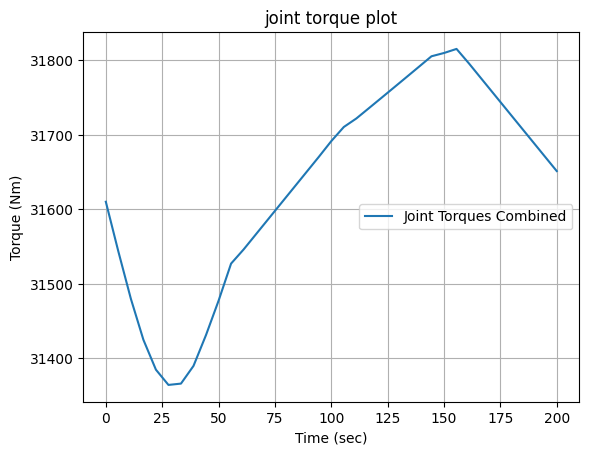

Joint Torques combined: 
 [[-5.43196178e+00  3.16101692e+04  7.83535408e+03  1.48390317e+03
  -8.04691608e+02 -3.80186375e-13]
 [-7.95343203e+00  3.15434467e+04  7.85111468e+03  1.48348449e+03
  -8.04806802e+02 -4.79093091e-13]
 [-9.80347985e+00  3.14798762e+04  7.86604771e+03  1.48350961e+03
  -8.04908663e+02 -6.56490690e-13]
 [-7.90892018e+00  3.14248836e+04  7.87834040e+03  1.48423515e+03
  -8.04855002e+02 -4.47828680e-13]
 [-5.06038682e+00  3.13847074e+04  7.88624419e+03  1.48544517e+03
  -8.04748200e+02  2.34768288e-13]
 [-1.60159047e+00  3.13642506e+04  7.88896403e+03  1.48698372e+03
  -8.04593681e+02  1.09721472e-12]
 [ 2.05020908e+00  3.13660186e+04  7.88621020e+03  1.48865512e+03
  -8.04404353e+02  1.60624668e-12]
 [ 5.45459941e+00  3.13897972e+04  7.87822001e+03  1.49025239e+03
  -8.04201824e+02  1.49027165e-12]
 [ 5.63951714e+00  3.14312893e+04  7.86540589e+03  1.49152997e+03
  -8.04118418e+02  8.88343966e-13]
 [ 7.96109854e+00  3.14772225e+04  7.84728190e+03  1.49211964e+03

In [ ]:
# Total time for trajectory
T_total = 200  # seconds
steps = 10  # Number of trajectory steps for smoothness
dt = T_total / steps  # Time step
radius = 0.05  # Radius of semicircle in cm

# q_init = np.array([-pi/4, pi/5, pi/4, pi/6, pi/4, pi/6])
q_init = np.array([pi/6, pi/6, pi/6, pi/6, pi/6, 0])

# Generate the semi-circle trajectory with center (5, 5)
target_positions, target_velocities, target_accelerations = generate_combined_trajectory(radius, 0.05, 0.10, steps, T_total)

print("dim of position",len(target_positions))
print("dim of velocity",len(target_velocities))
print("dim of velocity",len(target_accelerations))

num_points = len(target_positions)  # Total number of points in the combined trajectory
# Create a time array with 3997 points, evenly spaced from 0 to T_total
time_array = np.linspace(0, T_total, num_points)
# Store joint angles and end-effector positions
joint_angles_combined = [q_init]
end_effector_positions_combined = []
joint_torque_combined = []


# Loop through each time step for the combined trajectory
for t in range(len(target_positions)):
    q_current = joint_angles_combined[-1]
    v_ee = np.concatenate((target_velocities[t], [0, 0, 0]))  # 6D velocity with no rotation (angular velocity is 0)
    # Compute joint velocities using inverse kinematics
    joint_velocities = compute_joint_velocities(q_current, v_ee)
    a_ee = np.concatenate((target_accelerations[t], [0, 0, 0])) 
    # Compute joint accelerations using inverse dynamics
    joint_acceleration = compute_joint_accelerations(q_current, joint_velocities, a_ee, dt)
    #Compute the Joint Torque as per the robot dynamics model
    joint_torque =  compute_torque(q_current, joint_velocities , joint_acceleration, F_tool)
    joint_torque_combined.append(joint_torque)
    # Integrate joint velocities to get joint angles
    # s  = s0 + u *t + 1/2 * a * t**2
    q_new = q_current + joint_velocities * dt + 0.5 * joint_acceleration * dt **2
    joint_angles_combined.append(q_new)
    print("joint Torque\n", joint_torque)

    # Calculate the end-effector position for the current joint configuration
    T = T0_EE_with_tool.evalf(subs={theta1: q_new[0], theta2: q_new[1], theta3: q_new[2], theta4: q_new[3], theta5: q_new[4], theta6: q_new[5]})
    end_effector_position = T[:3, 3]
    end_effector_positions_combined.append(np.array(end_effector_position).flatten())

# Convert end-effector positions to numpy array for plotting
end_effector_positions_combined = np.array(end_effector_positions_combined)
joint_torque_combined = np.array(joint_torque_combined)
# Plot the end-effector trajectory in the XY plane
plt.plot(time_array, joint_torque_combined[:, 1], label='Joint Torques Combined')
# plt.scatter(start_x, start_y, color='red')
plt.xlabel('Time (sec)')
plt.ylabel('Torque (Nm)')
plt.title('joint torque plot')
plt.legend(loc='center right')
plt.grid(True)
plt.show()

print("Joint Torques combined: \n", joint_torque_combined)

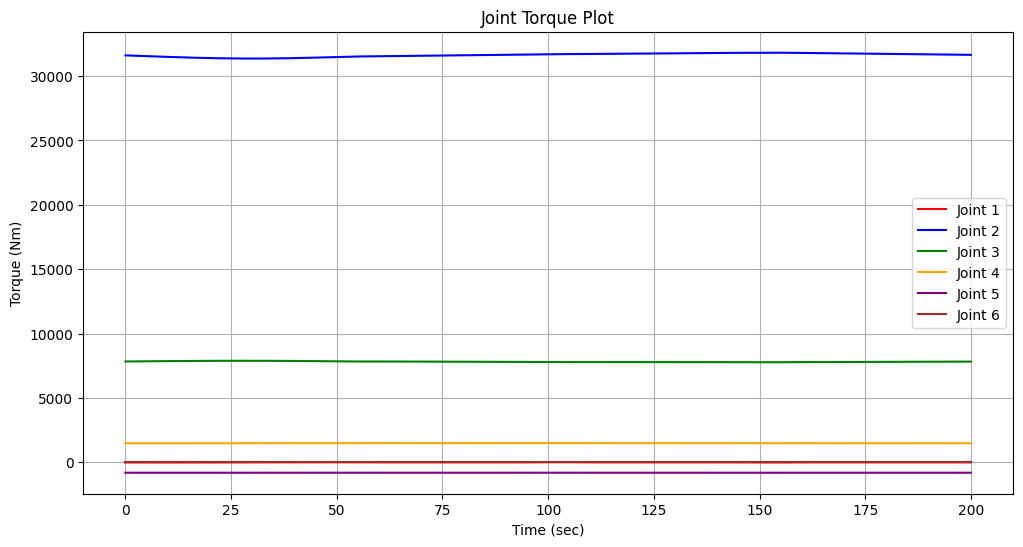

In [111]:
plt.figure(figsize=(12, 6))
joint_labels = ['Joint 1', 'Joint 2', 'Joint 3', 'Joint 4', 'Joint 5', 'Joint 6']
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']

for i in range(6):
    plt.plot(time_array, joint_torque_combined[:, i], label=joint_labels[i], color=colors[i])

plt.xlabel('Time (sec)')
plt.ylabel('Torque (Nm)')
plt.title('Joint Torque Plot')
plt.legend(loc='center right')
plt.grid(True)
plt.show()

In [93]:
# Example joint configuration
q = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
q_dot = np.array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06])
q_dot_dot = np.array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006])
# Compute mass matrix
M = compute_mass_matrix(q, masses, com)
print("Mass Matrix M(q):")
print(M)

# Compute gravity matrix
G = compute_gravity_matrix(q, masses, com)
print("\nGravity Matrix G(q):")
print(G)

# Compute potential energy
PE = compute_potential_energy(q, masses, com)
print("\nPotential Energy:")
print(PE)

# Assuming you have functions to compute M(q) and its derivative
M = compute_mass_matrix(q, masses, com)
print("Mass Matrix M(q):")
print(M)
# Method 1
C = compute_coriolis_matrix(q, q_dot)
print("Coriolis Matrix C(q,q_dot):")
print(C)

Mass Matrix M(q):
[[ 1.60803222e+06  1.59379785e+06  6.02566800e+05  1.35730106e+05
   6.59505528e+04 -4.07631815e-02]
 [ 1.59379785e+06  1.30403440e+07  5.28730773e+06  1.23088992e+06
  -5.67614959e+05  9.52558918e-02]
 [ 6.02566800e+05  5.28730773e+06  2.22576412e+06  5.26701863e+05
  -2.58827938e+05  9.52558918e-02]
 [ 1.35730106e+05  1.23088992e+06  5.26701863e+05  1.25495295e+05
  -6.32439610e+04  9.52558918e-02]
 [ 6.59505528e+04 -5.67614959e+05 -2.58827938e+05 -6.32439610e+04
   4.51116212e+04 -4.80676870e-18]
 [-4.07631815e-02  9.52558918e-02  9.52558918e-02  9.52558918e-02
  -4.04822184e-18  1.08543510e-01]]

Gravity Matrix G(q):
[ 0.00000000e+000  1.34646961e+004  3.15008590e+003  5.40944773e+002
 -3.90057221e+002 -6.49245329e-124]
Gravity Matrix: 
 [ 0.00000000e+000  1.34646961e+004  3.15008590e+003  5.40944773e+002
 -3.90057221e+002 -6.49245329e-124]

Potential Energy:
-3659.314290794916
Mass Matrix M(q):
[[ 1.60803222e+06  1.59379785e+06  6.02566800e+05  1.35730106e+05
   